In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from autokeras.keras_layers import ExpandLastDim
from autokeras.keras_layers import CastToFloat32
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SimpleRNN
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.applications import EfficientNetB7
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

ModuleNotFoundError: No module named 'autokeras'

# Make Input

In [3]:
def calculateWeight(tlx):
    tlx_weight = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Sum':[0]}
    tlx_weight = pd.DataFrame(tlx_weight)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col1 in range(1,len(tlx.columns)):
            for col2 in range(col1+1, len(tlx.columns)):
                if tlx[tlx.columns[col1]][i] > tlx[tlx.columns[col2]][i]:
                    score[col1-1]+=1
                elif tlx[tlx.columns[col1]][i] < tlx[tlx.columns[col2]][i]:
                    score[col2-1]+=1
                else :
                    score[col1-1]+=0.5
                    score[col2-1]+=0.5
                    
        score[6] = score[0]+score[1]+score[2]+score[3]+score[4]+score[5]
        tlx_weight.loc[i]=score
    #print(tlx_weight.loc[0])
    return tlx_weight

def calculate_tlxLevel(tlx, tlx_weight):
    result = {'Mental':[0], 
                  'Physical':[0], 
                  'Temporal':[0], 
                  'Effort':[0],
                  'Performance':[0],
                  'Frustration':[0],
                  'Score':[0]}
    result = pd.DataFrame(result)
    for i in range(len(tlx)):
        score = [0,0,0,0,0,0,0]
        for col in range(len(tlx_weight.columns)-1):
            score[col] = int(tlx[tlx.columns[col+1]].loc[i] * tlx_weight[tlx_weight.columns[col]].loc[i] )
        score[6] =int((score[0]+score[1]+score[2]+score[3]+score[4]+score[5] )/ tlx_weight[tlx_weight.columns[6]].loc[i]/10 + 0.5)
        if score[6]>10: score[6]=10
        if score[6]<0: score[6]=0
        result.loc[i]=score
    return result['Score']


In [4]:
def txtToDataframe_STEW(filename, flag1, flag2):
    file = open(filename, 'r')
    lines = file.readlines()
    datas = []
    for line in lines:
        txt = line.replace('   ', ' ').lstrip().rstrip().replace(' ', ',')
        data = txt.split(',')
        datas.append(data)
    df = pd.DataFrame(datas)
    df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'F8', 'AF4']
    df['label1']=flag1
    df['label2']=flag2
    return df


def getSTEWData(src) :
    file_list = os.listdir(src)
    
    rating = pd.DataFrame(pd.read_csv(src+'ratings.txt'))
    file_list.remove('ratings.txt')
    
    dataList=[]
    highList=[]
    lowList=[]
    
    print(rating.columns)
    j=0
    for i in rating['subject']:
        if i<10:
            num = str(0)+str(i)
        else:
            num = str(i)
        dataList.append(txtToDataframe_STEW(src+'sub'+num+'_hi.txt', 1,rating['test'][j]))
        dataList.append(txtToDataframe_STEW(src+'sub'+num+'_lo.txt', 0,rating['rest'][j]))
        highList.append(txtToDataframe_STEW(src+'sub'+num+'_hi.txt', 1,rating['test'][j]))
        lowList.append(txtToDataframe_STEW(src+'sub'+num+'_lo.txt', 0,rating['rest'][j]))
        j+=1
    return dataList, highList, lowList


In [5]:
def split_data(df, label, end):
    col = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7',
           'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
           'EEG.F8', 'EEG.AF4', 'MarkerValueInt']
    col_rename = ['AF3', 'F7', 'F3', 'FC5', 'T7',
           'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4',
           'F8', 'AF4', 'vis_name']
    data_extraction = df[col]
    data_extraction.columns = col_rename
    rest = data_extraction[data_extraction.vis_name == 0]
    survey = data_extraction[data_extraction.vis_name == 100]
    
    vis = data_extraction[data_extraction.vis_name == 1].reset_index(drop=True)
    vis['label'] = label[0]
    vis.drop(['vis_name'], axis=1, inplace=True)
    
    for i in range(2,end):
        df = data_extraction[data_extraction.vis_name == i].reset_index(drop=True)
        df['label'] = label[i-1]
        df.drop(['vis_name'], axis=1, inplace=True)
        vis = pd.concat([vis,df], ignore_index=True, axis=0)
    return rest, survey, vis


NameError: name 'to_categorical' is not defined

In [ ]:
src = './STEW Dataset/'
originalData, highData, lowData = getSTEWData(src)

stewData = pd.concat([highData[0],highData[1]],ignore_index=True)
for i in range(2,len(highData)):
    stewData = pd.concat([mergedData,highData[i]],ignore_index=True)
stewData = mergedData.apply(pd.to_numeric)

label2=stewData['label2']
stewData=stewData.drop(['label1'],axis=1)
data2=stewData.drop(['label2'],axis=1)

In [ ]:
src = 'EEG data/User/'
files = os.listdir(src)

tlx=[]
for f in files:
    tlx.append(pd.read_csv(src+f))

src = 'EEG data/prepross/'
datas = os.listdir(src)

workloadLevel = []
for t in tlx:
    workloadLevel.append(calculate_tlxLevel(t, calculateWeight(t)))

eegData=[]
for d in datas:
    print(src+d)
    eegData.append(pd.read_csv(src+d))
    

cnt = 0
for eeg, label in zip (eegData, workloadLevel):
    if cnt == 0 :
        rest, survey, vis = split_data(eeg, label,21)
        cnt+=1
        continue
    elif cnt == 6:
        r, s, v = split_data(eeg, label,21)
    else:
        r, s, v = split_data(eeg, label, 22)
    
    rest = pd.concat([rest,r], ignore_index=True, axis=0)
    survey = pd.concat([survey,s], ignore_index=True, axis=0)
    vis = pd.concat([vis,v], ignore_index=True, axis=0)
    cnt+=1

In [143]:
label2=mergedData['label2']
label=vis['label']


label2 = to_categorical(label2,11)
label = to_categorical(label,11)


print(label.shape, label2.shape)

(1731369, 11) (864000, 11)


In [147]:
stewData.to_csv("EEG data/stew.csv")
vis.to_csv("EEG data/eeg.csv")

In [114]:
data=vis.drop(['label'],axis=1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
data = pd.DataFrame(scaled, columns = data.columns, index=data.index)
data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0.508362,0.517284,0.525088,0.537682,0.511737,0.544149,0.526163,0.473225,0.517934,0.499212,0.502467,0.501600,0.460104,0.508060
1,0.506441,0.516182,0.523085,0.539412,0.509439,0.541593,0.524646,0.471761,0.514887,0.497846,0.502186,0.500885,0.459751,0.506115
2,0.504839,0.514410,0.520843,0.536789,0.506289,0.537854,0.523461,0.471045,0.513455,0.494746,0.498516,0.499884,0.457870,0.504207
3,0.504021,0.513072,0.521026,0.534593,0.507213,0.538140,0.523498,0.470929,0.513981,0.494045,0.497779,0.499598,0.458086,0.504643
4,0.503025,0.510974,0.520659,0.532287,0.508498,0.538979,0.523313,0.469798,0.513527,0.494220,0.498780,0.499258,0.457773,0.505279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731364,0.525264,0.515784,0.525897,0.526947,0.504534,0.534573,0.519835,0.470563,0.523101,0.530071,0.499745,0.511842,0.474914,0.548821
1731365,0.522453,0.513596,0.524445,0.525775,0.504425,0.532418,0.518410,0.469681,0.520780,0.526236,0.499605,0.509411,0.473543,0.545932
1731366,0.522062,0.513506,0.525364,0.526743,0.505511,0.532246,0.518281,0.469947,0.520255,0.532523,0.499377,0.510162,0.472544,0.545078
1731367,0.521830,0.513451,0.526338,0.527338,0.505059,0.532799,0.518447,0.470979,0.521651,0.548881,0.499499,0.510788,0.471408,0.543697


In [115]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data2)
data2 = pd.DataFrame(scaled, columns = data2.columns, index=data2.index)
data2

,AF3,F7,F3,FC5,T7,O1,O2,P8,T8,FC6,F4,F8,F8,AF4
0,0.569042,0.452258,0.537985,0.553295,0.478665,0.449631,0.482450,0.542340,0.558323,0.505813,0.479338,0.521798,0.533296,0.494656
1,0.568976,0.451482,0.538394,0.550698,0.478599,0.449895,0.483076,0.543015,0.558871,0.506793,0.480193,0.521187,0.535799,0.490618
2,0.567731,0.451223,0.538665,0.551317,0.478534,0.450158,0.483952,0.543629,0.559726,0.508383,0.479766,0.519600,0.538119,0.488070
3,0.567666,0.452775,0.538122,0.556078,0.480350,0.450357,0.484202,0.544427,0.560153,0.508873,0.480681,0.520759,0.537874,0.491798
4,0.568910,0.453422,0.537782,0.557129,0.481972,0.450753,0.484076,0.544489,0.560032,0.508444,0.482268,0.522042,0.538057,0.493351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863995,0.523429,0.476970,0.481127,0.513231,0.539819,0.475046,0.498530,0.511943,0.522736,0.483846,0.580479,0.559347,0.561497,0.558345
863996,0.523495,0.476906,0.480786,0.513911,0.540337,0.475113,0.496277,0.508567,0.522248,0.482866,0.580235,0.558982,0.560886,0.559153
863997,0.523364,0.477423,0.481399,0.514035,0.540986,0.476103,0.497091,0.508137,0.523347,0.482989,0.580175,0.558920,0.561191,0.559090
863998,0.522905,0.477035,0.480175,0.513231,0.541115,0.478876,0.500595,0.509978,0.524385,0.483478,0.578953,0.558432,0.560642,0.556853


In [13]:
def windowing_dataset(data, label, window_size):
    data_list = []
    label_list = []
    
    for i in range(0,len(data)//window_size,window_size):
        data_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i]))
    return np.array(data_list), np.array(label_list)

In [95]:
X_train, y_train = windowing_dataset(data,pd.DataFrame(label),14)
x, y = windowing_dataset(data2,pd.DataFrame(label2),14)
X_valid, X_test, y_valid, y_test = train_test_split(x,y, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y)

print(X_train.shape, X_test.shape, X_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

(8834, 14, 14) (2205, 14, 14) (2204, 14, 14) (2204, 11) (8834, 11) (2205, 11)


In [96]:
def Model2_2_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_2_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(11, activation='sigmoid'))
    
    model.summary()
    return model

def Model2_2_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

In [101]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def drawResult(history):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()
    
def runModel(model, crossentropy, x_train, y_train, x_valid, y_valid):
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model.compile(optimizer='adam', loss= crossentropy, metrics='accuracy')

    history = model.fit(x_train, y_train, 
                        epochs = 200, 
                        validation_data = (x_valid, y_valid), 
                        callbacks=[early_stop], verbose=1)
    drawResult(history)
    return model

def eval_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')

Epoch 1/200
277/277 [==============================] - 11s 37ms/step - loss: 1.0964 - accuracy: 0.4483 - val_loss: 6.0682 - val_accuracy: 0.0000e+00
Epoch 2/200
277/277 [==============================] - 10s 37ms/step - loss: 1.0653 - accuracy: 0.4551 - val_loss: 5.9436 - val_accuracy: 0.0000e+00
Epoch 3/200
277/277 [==============================] - 10s 37ms/step - loss: 1.0641 - accuracy: 0.4572 - val_loss: 4.9858 - val_accuracy: 0.0000e+00
Epoch 4/200
277/277 [==============================] - 11s 38ms/step - loss: 1.0630 - accuracy: 0.4556 - val_loss: 5.5458 - val_accuracy: 0.0000e+00
Epoch 5/200
277/277 [==============================] - 10s 35ms/step - loss: 1.0575 - accuracy: 0.4521 - val_loss: 5.5901 - val_accuracy: 0.0000e+00
Epoch 6/200
277/277 [==============================] - 10s 36ms/step - loss: 1.0573 - accuracy: 0.4609 - val_loss: 5.0629 - val_accuracy: 0.0000e+00
Epoch 7/200
277/277 [==============================] - 10s 35ms/step - loss: 1.0587 - accuracy: 0.4532 - v

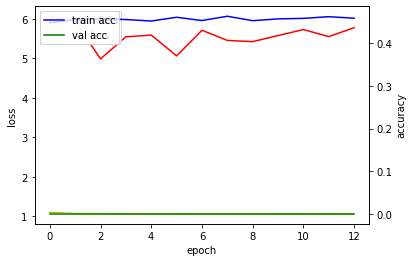

0.0
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_4 (ExpandLas (None, 14, 14, 1)         0         
_________________________________________________________________
cast_to_float32_4 (CastToFlo (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 512)       2560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 512)       1049088   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 128)    

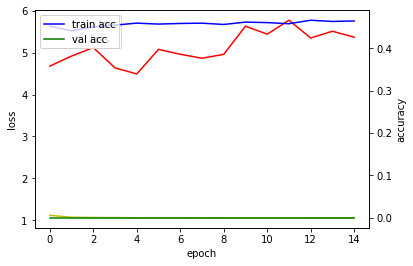

0.0
Epoch 1/200
277/277 [==============================] - 14s 47ms/step - loss: 1.1499 - accuracy: 0.4435 - val_loss: 3.9659 - val_accuracy: 0.0000e+00
Epoch 2/200
277/277 [==============================] - 12s 45ms/step - loss: 1.0883 - accuracy: 0.4509 - val_loss: 4.4253 - val_accuracy: 0.0000e+00
Epoch 3/200
277/277 [==============================] - 13s 47ms/step - loss: 1.0808 - accuracy: 0.4559 - val_loss: 4.1469 - val_accuracy: 0.0000e+00
Epoch 4/200
277/277 [==============================] - 13s 47ms/step - loss: 1.0702 - accuracy: 0.4596 - val_loss: 6.3981 - val_accuracy: 0.0000e+00
Epoch 5/200
277/277 [==============================] - 13s 45ms/step - loss: 1.0682 - accuracy: 0.4634 - val_loss: 4.3191 - val_accuracy: 0.0000e+00
Epoch 6/200
277/277 [==============================] - 12s 44ms/step - loss: 1.0662 - accuracy: 0.4612 - val_loss: 4.3197 - val_accuracy: 0.0000e+00
Epoch 7/200
277/277 [==============================] - 12s 44ms/step - loss: 1.0632 - accuracy: 0.4651

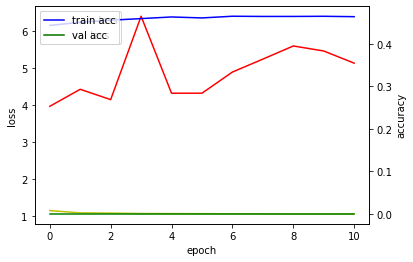

0.0


In [102]:
crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_2_1(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_2_2(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_2_3(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))

(4409, 14, 14) (4417, 14, 14) (4417, 14, 14) (4417, 11) (4409, 11) (4417, 11)
Epoch 1/200
138/138 [==============================] - 5s 33ms/step - loss: 0.5355 - accuracy: 0.6893 - val_loss: 10.0481 - val_accuracy: 0.0607
Epoch 2/200
138/138 [==============================] - 4s 30ms/step - loss: 0.4384 - accuracy: 0.7235 - val_loss: 12.7571 - val_accuracy: 0.0607
Epoch 3/200
138/138 [==============================] - 4s 30ms/step - loss: 0.4233 - accuracy: 0.7274 - val_loss: 13.1782 - val_accuracy: 0.0607.4296 
Epoch 4/200
138/138 [==============================] - 4s 30ms/step - loss: 0.4278 - accuracy: 0.7308 - val_loss: 6.7479 - val_accuracy: 0.0607
Epoch 5/200
138/138 [==============================] - 4s 30ms/step - loss: 0.4102 - accuracy: 0.7562 - val_loss: 12.6672 - val_accuracy: 0.0607
Epoch 6/200
138/138 [==============================] - 4s 30ms/step - loss: 0.3977 - accuracy: 0.7603 - val_loss: 11.4605 - val_accuracy: 0.0607 loss: 0.3995 - 
Epoch 7/200
138/138 [==========

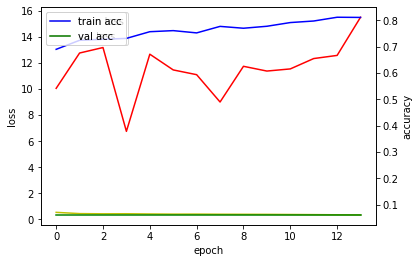

0.028601921024546426
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_7 (ExpandLas (None, 14, 14, 1)         0         
_________________________________________________________________
cast_to_float32_7 (CastToFlo (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 512)       2560      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 512)       1049088   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
conv2d_25 (Conv2D)           (Non

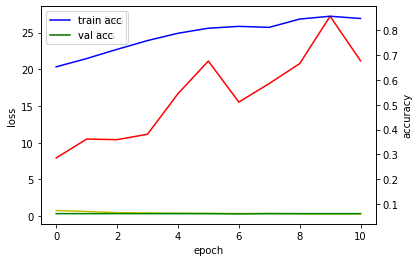

0.022920675646782126
Epoch 1/200
138/138 [==============================] - 6s 39ms/step - loss: 0.7514 - accuracy: 0.6530 - val_loss: 10.0326 - val_accuracy: 0.0607
Epoch 2/200
138/138 [==============================] - 5s 36ms/step - loss: 0.6387 - accuracy: 0.6861 - val_loss: 17.0873 - val_accuracy: 0.0607
Epoch 3/200
138/138 [==============================] - 5s 36ms/step - loss: 0.5266 - accuracy: 0.6888 - val_loss: 64.2681 - val_accuracy: 0.0607
Epoch 4/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4493 - accuracy: 0.6931 - val_loss: 38.4793 - val_accuracy: 0.0607
Epoch 5/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4363 - accuracy: 0.6958 - val_loss: 78.0870 - val_accuracy: 0.0607
Epoch 6/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4326 - accuracy: 0.6875 - val_loss: 84.7577 - val_accuracy: 0.0607
Epoch 7/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4204 - accuracy: 0.7065 - val_l

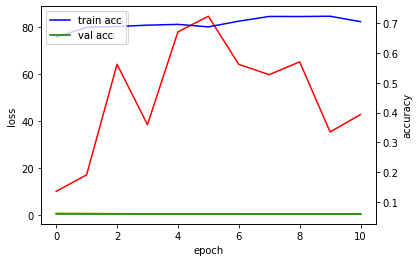

0.028601921024546426


In [125]:
x, y = windowing_dataset(data,pd.DataFrame(label),14)
X_train, y_train = windowing_dataset(data2,pd.DataFrame(label2),14)
X_valid, X_test, y_valid, y_test = train_test_split(x,y, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y)

print(X_train.shape, X_test.shape, X_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_2_1(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_2_2(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_2_3(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))

(7945, 14, 14) (2649, 14, 14) (2648, 14, 14) (2648, 11) (7945, 11) (2649, 11)
Epoch 1/200
249/249 [==============================] - 7s 27ms/step - loss: 40.3076 - accuracy: 0.3825 - val_loss: 1.2023 - val_accuracy: 0.4147
Epoch 2/200
249/249 [==============================] - 6s 25ms/step - loss: 1.2022 - accuracy: 0.4149 - val_loss: 1.1991 - val_accuracy: 0.4147
Epoch 3/200
249/249 [==============================] - 6s 25ms/step - loss: 1.2007 - accuracy: 0.4146 - val_loss: 1.1996 - val_accuracy: 0.4147
Epoch 4/200
249/249 [==============================] - 6s 25ms/step - loss: 1.2010 - accuracy: 0.4147 - val_loss: 1.1992 - val_accuracy: 0.4147
Epoch 5/200
249/249 [==============================] - 6s 26ms/step - loss: 1.2021 - accuracy: 0.4147 - val_loss: 1.2000 - val_accuracy: 0.4147
Epoch 6/200
249/249 [==============================] - 6s 25ms/step - loss: 1.2005 - accuracy: 0.4147 - val_loss: 1.2000 - val_accuracy: 0.4147
Epoch 7/200
249/249 [==============================] - 6s

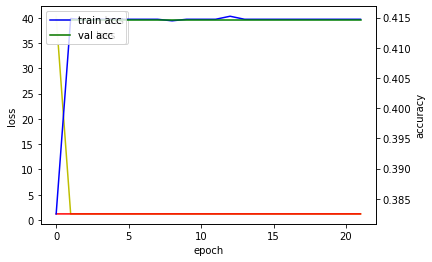

0.1465172137710168
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_last_dim_18 (ExpandLa (None, 14, 14, 1)         0         
_________________________________________________________________
cast_to_float32_18 (CastToFl (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 13, 13, 512)       2560      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 12, 12, 512)       1049088   
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
conv2d_71 (Conv2D)           (None

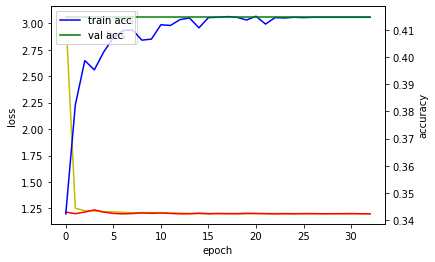

0.1465172137710168
Epoch 1/200
249/249 [==============================] - 8s 31ms/step - loss: 3.6971 - accuracy: 0.3447 - val_loss: 1.2236 - val_accuracy: 0.4147
Epoch 2/200
249/249 [==============================] - 7s 30ms/step - loss: 1.2865 - accuracy: 0.3736 - val_loss: 1.2155 - val_accuracy: 0.4147
Epoch 3/200
249/249 [==============================] - 8s 31ms/step - loss: 1.2615 - accuracy: 0.3804 - val_loss: 1.2014 - val_accuracy: 0.4147
Epoch 4/200
249/249 [==============================] - 8s 30ms/step - loss: 1.2477 - accuracy: 0.3951 - val_loss: 1.2056 - val_accuracy: 0.4147
Epoch 5/200
249/249 [==============================] - 8s 30ms/step - loss: 1.2384 - accuracy: 0.3966 - val_loss: 1.2011 - val_accuracy: 0.4147
Epoch 6/200
249/249 [==============================] - 8s 30ms/step - loss: 1.2286 - accuracy: 0.4070 - val_loss: 1.2006 - val_accuracy: 0.4147
Epoch 7/200
249/249 [==============================] - 8s 30ms/step - loss: 1.2240 - accuracy: 0.4079 - val_loss: 1.2

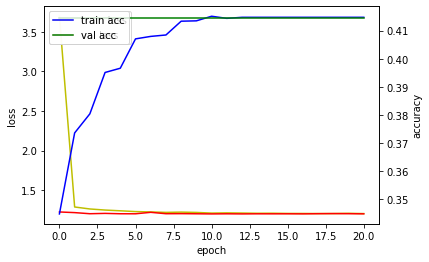

0.1465172137710168


In [155]:
x, y = windowing_dataset(mergedData, pd.DataFrame(mergedLabel),14)
X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y_test)


print(X_train.shape, X_test.shape, X_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_2_1(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_2_2(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_2_3(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))

In [128]:
def Model2_1_1():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_1_2():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(2,2), strides=(1,1), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

def Model2_1_3():
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 14)))
    model.add(ExpandLastDim())
    model.add(CastToFloat32())
    
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(Conv2D(512, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(4,4), strides=(1,1), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(11, activation='sigmoid'))
    
    #model.summary()
    return model

(8834, 14, 14) (2205, 14, 14) (2204, 14, 14) (2204, 11) (8834, 11) (2205, 11)
Epoch 1/200
277/277 [==============================] - 7s 25ms/step - loss: 1.0892 - accuracy: 0.4433 - val_loss: 6.3965 - val_accuracy: 0.0000e+00
Epoch 2/200
277/277 [==============================] - 7s 24ms/step - loss: 1.0690 - accuracy: 0.4521 - val_loss: 6.2165 - val_accuracy: 0.0000e+00
Epoch 3/200
277/277 [==============================] - 7s 24ms/step - loss: 1.0636 - accuracy: 0.4512 - val_loss: 5.2776 - val_accuracy: 0.0000e+00
Epoch 4/200
277/277 [==============================] - 7s 24ms/step - loss: 1.0598 - accuracy: 0.4527 - val_loss: 5.4215 - val_accuracy: 0.0000e+00
Epoch 5/200
277/277 [==============================] - 7s 25ms/step - loss: 1.0597 - accuracy: 0.4532 - val_loss: 5.2500 - val_accuracy: 0.0000e+00
Epoch 6/200
277/277 [==============================] - 7s 25ms/step - loss: 1.0592 - accuracy: 0.4545 - val_loss: 5.9191 - val_accuracy: 0.0000e+00
Epoch 7/200
277/277 [=============

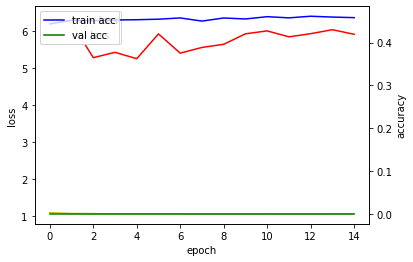

0.0
Epoch 1/200
277/277 [==============================] - 5s 16ms/step - loss: 1.1274 - accuracy: 0.4472 - val_loss: 4.5972 - val_accuracy: 0.0000e+00
Epoch 2/200
277/277 [==============================] - 4s 16ms/step - loss: 1.0705 - accuracy: 0.4561 - val_loss: 4.9864 - val_accuracy: 0.0000e+00
Epoch 3/200
277/277 [==============================] - 4s 16ms/step - loss: 1.0657 - accuracy: 0.4545 - val_loss: 4.3716 - val_accuracy: 0.0000e+00
Epoch 4/200
277/277 [==============================] - 4s 15ms/step - loss: 1.0658 - accuracy: 0.4519 - val_loss: 4.6199 - val_accuracy: 0.0000e+00
Epoch 5/200
277/277 [==============================] - 4s 15ms/step - loss: 1.0618 - accuracy: 0.4510 - val_loss: 4.6595 - val_accuracy: 0.0000e+00
Epoch 6/200
277/277 [==============================] - 4s 16ms/step - loss: 1.0609 - accuracy: 0.4573 - val_loss: 4.9524 - val_accuracy: 0.0000e+00
Epoch 7/200
277/277 [==============================] - 4s 16ms/step - loss: 1.0597 - accuracy: 0.4563 - val_

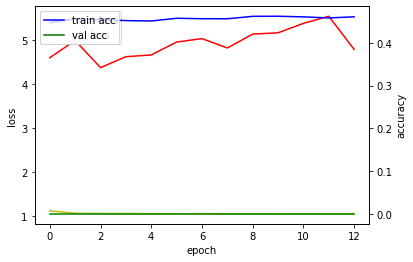

0.0
Epoch 1/200
277/277 [==============================] - 9s 31ms/step - loss: 1.2166 - accuracy: 0.4379 - val_loss: 4.5148 - val_accuracy: 0.0000e+00
Epoch 2/200
277/277 [==============================] - 8s 30ms/step - loss: 1.1015 - accuracy: 0.4510 - val_loss: 4.7431 - val_accuracy: 0.0000e+00
Epoch 3/200
277/277 [==============================] - 8s 30ms/step - loss: 1.0801 - accuracy: 0.4587 - val_loss: 5.6740 - val_accuracy: 0.0000e+00
Epoch 4/200
277/277 [==============================] - 8s 29ms/step - loss: 1.0758 - accuracy: 0.4512 - val_loss: 4.9286 - val_accuracy: 0.0000e+00
Epoch 5/200
277/277 [==============================] - 8s 30ms/step - loss: 1.0739 - accuracy: 0.4580 - val_loss: 7.9777 - val_accuracy: 0.0000e+00
Epoch 6/200
277/277 [==============================] - 8s 30ms/step - loss: 1.0741 - accuracy: 0.4529 - val_loss: 6.0729 - val_accuracy: 0.0000e+00
Epoch 7/200
277/277 [==============================] - 8s 29ms/step - loss: 1.0718 - accuracy: 0.4560 - val_

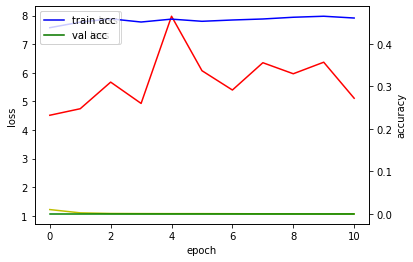

0.0


In [129]:
X_train, y_train = windowing_dataset(data,pd.DataFrame(label),14)
x, y = windowing_dataset(data2,pd.DataFrame(label2),14)
X_valid, X_test, y_valid, y_test = train_test_split(x,y, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y)

print(X_train.shape, X_test.shape, X_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_1_1(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_1_2(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_1_3(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))

(4409, 14, 14) (4417, 14, 14) (4417, 14, 14) (4417, 11) (4409, 11) (4417, 11)
Epoch 1/200
138/138 [==============================] - 5s 31ms/step - loss: 0.5470 - accuracy: 0.6868 - val_loss: 9.6437 - val_accuracy: 0.0607
Epoch 2/200
138/138 [==============================] - 4s 32ms/step - loss: 0.4425 - accuracy: 0.7144 - val_loss: 11.5606 - val_accuracy: 0.0607
Epoch 3/200
138/138 [==============================] - 4s 32ms/step - loss: 0.4284 - accuracy: 0.7242 - val_loss: 10.0428 - val_accuracy: 0.0607
Epoch 4/200
138/138 [==============================] - 4s 30ms/step - loss: 0.4195 - accuracy: 0.7342 - val_loss: 8.4671 - val_accuracy: 0.0607
Epoch 5/200
138/138 [==============================] - 4s 31ms/step - loss: 0.4073 - accuracy: 0.7435 - val_loss: 9.6529 - val_accuracy: 0.0607
Epoch 6/200
138/138 [==============================] - 4s 32ms/step - loss: 0.3986 - accuracy: 0.7580 - val_loss: 11.4550 - val_accuracy: 0.0607
Epoch 7/200
138/138 [==============================] - 

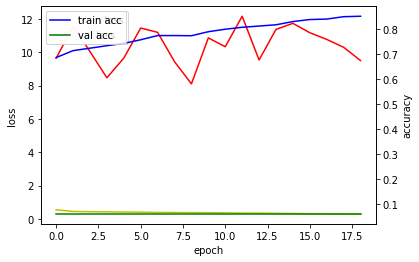

0.0228864218616567
Epoch 1/200
138/138 [==============================] - 4s 20ms/step - loss: 0.7232 - accuracy: 0.6707 - val_loss: 10.6288 - val_accuracy: 0.0607
Epoch 2/200
138/138 [==============================] - 3s 19ms/step - loss: 0.5220 - accuracy: 0.7056 - val_loss: 9.9640 - val_accuracy: 0.0607
Epoch 3/200
138/138 [==============================] - 3s 19ms/step - loss: 0.4220 - accuracy: 0.7666 - val_loss: 8.9941 - val_accuracy: 0.0607
Epoch 4/200
138/138 [==============================] - 3s 19ms/step - loss: 0.3995 - accuracy: 0.7757 - val_loss: 14.0732 - val_accuracy: 0.0607
Epoch 5/200
138/138 [==============================] - 3s 19ms/step - loss: 0.3751 - accuracy: 0.7938 - val_loss: 15.0031 - val_accuracy: 0.0607
Epoch 6/200
138/138 [==============================] - 3s 19ms/step - loss: 0.3465 - accuracy: 0.8242 - val_loss: 12.0640 - val_accuracy: 0.0600
Epoch 7/200
138/138 [==============================] - 3s 19ms/step - loss: 0.3279 - accuracy: 0.8226 - val_loss:

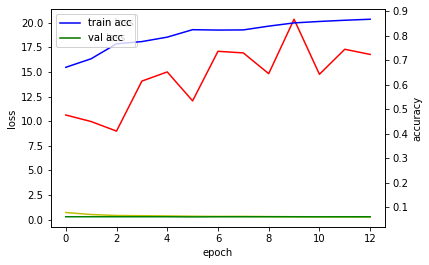

0.02291577597263788
Epoch 1/200
138/138 [==============================] - 6s 37ms/step - loss: 0.9010 - accuracy: 0.6063 - val_loss: 9.8950 - val_accuracy: 0.0607
Epoch 2/200
138/138 [==============================] - 5s 36ms/step - loss: 0.6654 - accuracy: 0.6602 - val_loss: 8.5082 - val_accuracy: 0.0607
Epoch 3/200
138/138 [==============================] - 5s 36ms/step - loss: 0.6358 - accuracy: 0.6875 - val_loss: 10.8834 - val_accuracy: 0.0607
Epoch 4/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4748 - accuracy: 0.6981 - val_loss: 22.0090 - val_accuracy: 0.0607
Epoch 5/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4525 - accuracy: 0.6861 - val_loss: 28.1645 - val_accuracy: 0.0607
Epoch 6/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4347 - accuracy: 0.7024 - val_loss: 13.6853 - val_accuracy: 0.0607
Epoch 7/200
138/138 [==============================] - 5s 36ms/step - loss: 0.4438 - accuracy: 0.6904 - val_loss

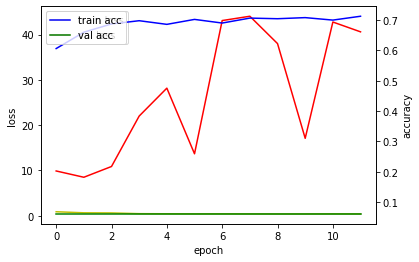

0.028601921024546426


In [130]:
x, y = windowing_dataset(data,pd.DataFrame(label),14)
X_train, y_train = windowing_dataset(data2,pd.DataFrame(label2),14)
X_valid, X_test, y_valid, y_test = train_test_split(x,y, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y)

print(X_train.shape, X_test.shape, X_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_1_1(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_1_2(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_1_3(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))

(7945, 14, 14) (2649, 14, 14) (2648, 14, 14) (2648, 11) (7945, 11) (2649, 11)
Epoch 1/200
249/249 [==============================] - 7s 26ms/step - loss: 35.2300 - accuracy: 0.3972 - val_loss: 1.1999 - val_accuracy: 0.4147
Epoch 2/200
249/249 [==============================] - 6s 26ms/step - loss: 1.2029 - accuracy: 0.4147 - val_loss: 1.1998 - val_accuracy: 0.4147
Epoch 3/200
249/249 [==============================] - 6s 26ms/step - loss: 1.2020 - accuracy: 0.4147 - val_loss: 1.2002 - val_accuracy: 0.4147
Epoch 4/200
249/249 [==============================] - 6s 26ms/step - loss: 1.2017 - accuracy: 0.4147 - val_loss: 1.2004 - val_accuracy: 0.4147
Epoch 5/200
249/249 [==============================] - 6s 25ms/step - loss: 1.2025 - accuracy: 0.4147 - val_loss: 1.2003 - val_accuracy: 0.4147
Epoch 6/200
249/249 [==============================] - 6s 26ms/step - loss: 1.2002 - accuracy: 0.4146 - val_loss: 1.1990 - val_accuracy: 0.4147
Epoch 7/200
249/249 [==============================] - 6s

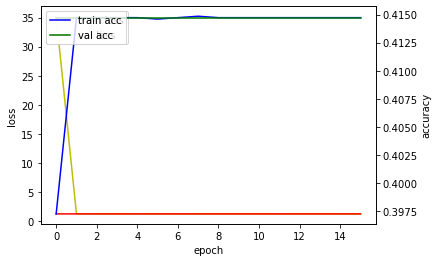

0.1465172137710168
Epoch 1/200
249/249 [==============================] - 5s 17ms/step - loss: 3.1156 - accuracy: 0.3650 - val_loss: 1.2809 - val_accuracy: 0.4147
Epoch 2/200
249/249 [==============================] - 4s 17ms/step - loss: 1.2377 - accuracy: 0.4034 - val_loss: 1.2096 - val_accuracy: 0.4147
Epoch 3/200
249/249 [==============================] - 4s 17ms/step - loss: 1.2115 - accuracy: 0.4070 - val_loss: 1.2273 - val_accuracy: 0.4147
Epoch 4/200
249/249 [==============================] - 4s 16ms/step - loss: 1.2104 - accuracy: 0.4084 - val_loss: 1.2026 - val_accuracy: 0.4147
Epoch 5/200
249/249 [==============================] - 4s 17ms/step - loss: 1.2078 - accuracy: 0.4112 - val_loss: 1.2016 - val_accuracy: 0.4147
Epoch 6/200
249/249 [==============================] - 4s 17ms/step - loss: 1.2076 - accuracy: 0.4103 - val_loss: 1.2008 - val_accuracy: 0.4147
Epoch 7/200
249/249 [==============================] - 4s 17ms/step - loss: 1.2068 - accuracy: 0.4135 - val_loss: 1.2

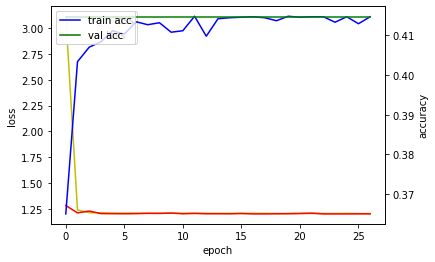

0.1465172137710168
Epoch 1/200
249/249 [==============================] - 8s 31ms/step - loss: 3.9521 - accuracy: 0.3398 - val_loss: 1.2134 - val_accuracy: 0.4147
Epoch 2/200
249/249 [==============================] - 8s 31ms/step - loss: 1.3235 - accuracy: 0.3607 - val_loss: 1.2174 - val_accuracy: 0.4147
Epoch 3/200
249/249 [==============================] - 8s 31ms/step - loss: 1.3015 - accuracy: 0.3593 - val_loss: 1.2089 - val_accuracy: 0.4147
Epoch 4/200
249/249 [==============================] - 8s 31ms/step - loss: 1.2905 - accuracy: 0.3601 - val_loss: 1.2023 - val_accuracy: 0.4147
Epoch 5/200
249/249 [==============================] - 8s 31ms/step - loss: 1.2628 - accuracy: 0.3751 - val_loss: 1.2144 - val_accuracy: 0.4143
Epoch 6/200
249/249 [==============================] - 8s 31ms/step - loss: 1.2580 - accuracy: 0.3792 - val_loss: 1.2071 - val_accuracy: 0.4147
Epoch 7/200
249/249 [==============================] - 8s 31ms/step - loss: 1.2465 - accuracy: 0.3932 - val_loss: 1.2

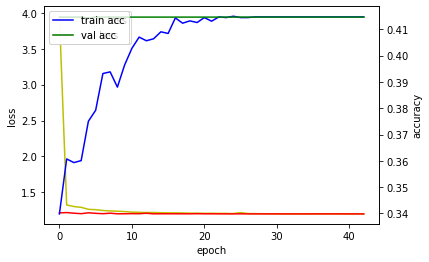

0.1465172137710168


In [156]:
x, y = windowing_dataset(mergedData, pd.DataFrame(mergedLabel),14)
X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.6, 
                                                    random_state=True,
                                                    stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, train_size=0.5, 
                                                    random_state=True,
                                                    stratify = y_test)


print(X_train.shape, X_test.shape, X_valid.shape,y_valid.shape,y_train.shape, y_test.shape)

crossentropy = 'categorical_crossentropy'

print(eval_model(runModel(Model2_1_1(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_1_2(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))
print(eval_model(runModel(Model2_1_3(),crossentropy,
                          X_train, y_train, X_valid, y_valid), X_test, y_test))

# AUTO KERAS

In [21]:
import autokeras as ak
from tensorflow.keras.utils import plot_model
from datetime import datetime

In [18]:
mergedData = pd.read_csv("EEG data/eeg.csv")
mergedData.drop(['Unnamed: 0'], axis=1, inplace=True)
mergedLabel = mergedData['label']
mergedLabel = to_categorical(mergedLabel,11)
mergedData.drop(['label'], axis=1, inplace=True)

In [19]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(mergedData)

mergedData = pd.DataFrame(mergedData, columns = mergedData.columns, index=mergedData.index)

x, y = windowing_dataset(mergedData, pd.DataFrame(mergedLabel),14)
X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.7, random_state=True ,stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9269, 14, 14) (3973, 14, 14) (9269, 11) (3973, 11)


In [22]:
trials=[3] #,5,10,20]
for trial in trials:
    clf_ = ak.ImageClassifier(overwrite=True, max_trials=trial)
    clf_.fit(x=X_train, y=y_train, epochs=20)

    predicted_y = clf_.predict(X_test)
    print(predicted_y)
    loss, acc = clf_.evaluate(X_test, Y_test)
    print(clf_.evaluate(X_test, y_test))
    print('Loss: %.3f   Accuracy: %.3f' % (loss,acc))

    model = clf_.export_model()
    model.summary()
    plot_model(model, show_shapes=True)
    tmp = int(acc*100)
    print(tmp)
    model.save('model/'+'_ACC_'+str(tmp)+'_try_'+trial+'_.h5')

Trial 2 Complete [00h 33m 50s]
val_loss: 1.1219675540924072

Best val_loss So Far: 0.927096426486969
Total elapsed time: 00h 34m 29s

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
image_block_1/b...|efficient         |vanilla           
image_block_1/n...|True              |True              
image_block_1/a...|True              |False             
image_block_1/i...|True              |None              
image_block_1/i...|False             |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0                 |None              
image_block_1/i...|0.1               |None              
image_block_1/i...|0                 |None              
image_block_1/e...|True              |None              
image_block_1/e...|b7                |None              
image_block_1/e...|True              |None              
image_block_1/e...|True              |None              
classification_...|global_avg        |flat

KeyboardInterrupt: 